# Setup

In [1]:
import pandas as pd
import numpy as np

import os

from datetime import datetime
import time

import seaborn as sns
import matplotlib.pyplot as plt

import statistics


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the Iris dataset
# iris = load_iris()
# X = iris.data
# y = iris.target

import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.path.exists('dftrain.csv'):
    dftrain = pd.read_csv('dftrain.csv')
if os.path.exists('dftest.csv'):
    dftest = pd.read_csv('dftest.csv')

In [69]:
df = pd.read_csv('train_cleaned.csv')

# LDA (complete)

In [4]:
def lda_complete(taxi_id, is_cut=True, cutoff=0.5, test_size=0.99):
    newtrain=dftrain[dftrain['TAXI_ID'] == taxi_id]
    
    train_corr=newtrain[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY']].corr()
    positive_corr_list=list(train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().keys())
    positive_corr_list.remove('TRAVEL_TIME')
    
    ## outlier cut
    tmpdf = newtrain
    Q1 = tmpdf['TRAVEL_TIME'].quantile(0.25)
    Q2 = tmpdf['TRAVEL_TIME'].max()
    if is_cut:
        Q2 = tmpdf['TRAVEL_TIME'].quantile(cutoff)
    Q3 = tmpdf['TRAVEL_TIME'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q2

    new_train = newtrain[newtrain.TRAVEL_TIME >= lower_bound]
    new_train = newtrain[newtrain.TRAVEL_TIME <= upper_bound]

    print('upper_bound', upper_bound)
    
    avail_times = new_train.TRAVEL_TIME.unique()
    n = len(avail_times)
    range_ = list(range(n))
    labels = dict(zip(avail_times,range_))
    labels_rev = dict(zip(range_, avail_times))
    
    X = []
    y = []

    for row in new_train.iterrows():

        lst = []
        for elem in positive_corr_list:
            lst.append(row[1][elem])

        X.append(np.array(lst))
        y.append(np.array(labels[row[1]['TRAVEL_TIME']]))
    
    # Split the dataset into training and testing sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
    
    ytrain = []
    for i in y_train:
        ytrain.append(i.item())
        
    if len(set(ytrain)) >= len(X_train):
        return (None, None)
    
    # Create an LDA classifier
    lda = LinearDiscriminantAnalysis()

    # Fit the LDA model on the training data
    lda.fit(X_train, y_train)

    # Predict the class labels for the test data
    y_pred = lda.predict(X_train)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_train, y_pred)
    print("Training Accuracy:", accuracy)
    
    new_test = dftest[dftest.TAXI_ID == taxi_id]
    
    Xtest = []
    trips = []
    
    for row in new_test.iterrows():
        trips.append(row[1]['TRIP_ID'])
        lst = []
        for elem in positive_corr_list:#, 'WEEKDAY']:
            lst.append(row[1][elem])
        Xtest.append(np.array(lst))
    
    preds = lda.predict(Xtest)
    r = len(preds)
    output = []
    for i in range(r):
        print(trips[i], labels_rev[preds[i]])
        output.append(labels_rev[preds[i]])
    return (trips, output)

# Individual experiments

## T1, T308

In [179]:
dftest[dftest.TAXI_ID == 20000542]

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TIMESTAMP
0,T1,20000542,2014,8,33,14,17,57,3,0,1,0,1,1,0,1408039037
300,T308,20000542,2014,12,51,21,11,41,6,0,0,1,1,1,0,1419162114


In [195]:
for cutoff in [0.5, 0.75, 0.99]:
    lda_complete(taxi_id=20000542, is_cut=True, cutoff=cutoff, test_size=0.99)
    print()

upper_bound 630.0
Validation Accuracy: 0.43333333333333335
T1 390
T308 525

upper_bound 870.0
Validation Accuracy: 0.5116279069767442
T1 675
T308 0

upper_bound 3055.050000000001
Validation Accuracy: 0.42105263157894735
T1 495
T308 390



## T2, T249

In [28]:
dftest[dftest.TAXI_ID == 20000108]

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TIMESTAMP
1,T2,20000108,2014,8,33,14,17,50,3,0,1,0,1,1,0,1408038611
241,T249,20000108,2014,11,44,1,3,56,5,0,0,1,1,1,0,1414814185


In [57]:
for cutoff in [0.5, 0.75, 0.99]:
    lda_complete(taxi_id=20000108, is_cut=True, cutoff=cutoff)
    print('')

upper_bound 585.0
Validation Accuracy: 0.3333333333333333
T2 405
T249 450

upper_bound 825.0
Validation Accuracy: 0.34146341463414637
T2 480
T249 315

upper_bound 2265.0
Validation Accuracy: 0.25925925925925924
T2 360
T249 150



## T3

In [34]:
dftest[dftest.TAXI_ID == 20000370]

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TIMESTAMP
2,T3,20000370,2014,8,33,14,17,49,3,0,1,0,1,1,0,1408038568


In [62]:
for cutoff in [0.5, 0.75, 0.99]:
    lda_complete(taxi_id=20000370, is_cut=True, cutoff=cutoff)
    print('')

upper_bound 555.0
Validation Accuracy: 0.75
T3 510

upper_bound 780.0
Validation Accuracy: 0.7714285714285715
T3 480

upper_bound 1974.149999999995
Validation Accuracy: 0.6444444444444445
T3 540



## T4, T250

In [50]:
dftest[dftest.TAXI_ID == 20000492]

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TIMESTAMP
3,T4,20000492,2014,8,33,14,17,58,3,0,1,0,1,1,0,1408039090
242,T250,20000492,2014,11,44,1,3,54,5,0,1,0,1,1,0,1414814069


In [64]:
for cutoff in [0.5, 0.75, 0.99]:
    lda_complete(20000492, is_cut=True, cutoff=cutoff)
    print('')

upper_bound 540.0
Validation Accuracy: 0.5277777777777778
T4 465
T250 315

upper_bound 780.0
Validation Accuracy: 0.37037037037037035
T4 765
T250 570

upper_bound 2164.5000000000027
Validation Accuracy: 0.2714285714285714
T4 1575
T250 150



# Try to scale

In [66]:
taxi_ids=list(dftest.TAXI_ID)

In [197]:
all_trips = []
all_preds = []
not_ok = []
for taxi_id in taxi_ids:
    if taxi_id in [20000079, 20000206]:
        continue
    print('----------------------')
    print(taxi_id)
    trips, output = lda_complete(taxi_id=taxi_id, is_cut=True, cutoff=0.5)
    if output is None:
        not_ok.append(taxi_id)
    else:
        r = len(trips)

        for i in range(r):
            all_trips.append(trips[i])
            all_preds.append(output[i])

----------------------
20000542
upper_bound 630.0
Validation Accuracy: 0.43333333333333335
T1 390
T308 525
----------------------
20000108
upper_bound 585.0
Validation Accuracy: 0.3333333333333333
T2 405
T249 450
----------------------
20000370
upper_bound 555.0
Validation Accuracy: 0.75
T3 510
----------------------
20000492
upper_bound 540.0
Validation Accuracy: 0.5277777777777778
T4 465
T250 315
----------------------
20000621
upper_bound 540.0
Validation Accuracy: 0.6944444444444444
T5 495
----------------------
20000607
upper_bound 795.0
Validation Accuracy: 0.9411764705882353
T6 315
----------------------
20000310
upper_bound 585.0
Validation Accuracy: 0.7916666666666666
T7 300
----------------------
20000619
upper_bound 615.0
Validation Accuracy: 0.4666666666666667
T8 450
----------------------
20000503
upper_bound 510.0
Validation Accuracy: 0.5333333333333333
T9 255
T138 315
T252 240
----------------------
20000327
upper_bound 675.0
Validation Accuracy: 0.9285714285714286
T10 5

In [ ]:
# ValueError: With n_samples=52, test_size=0.99 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.
20000079

# ValueError: Internal work array size computation failed: -10
20000206

In [178]:
print(len(not_ok))
len(all_trips)

7


405

In [167]:
not_ok_2 = []
for taxi_id in not_ok:
#     if taxi_id in [20000079, 20000206]:
#         continue
    print('----------------------')
    print(taxi_id)
    trips, output = lda_complete(taxi_id=taxi_id, is_cut=True, cutoff=0.5, test_size=0.98)
    if output is None:
        not_ok_2.append(taxi_id)
    else:
        r = len(trips)

        for i in range(r):
            all_trips.append(trips[i])
            all_preds.append(output[i])

----------------------
20000312
upper_bound 1005.0
Validation Accuracy: 0.8
T14 345
T209 90
----------------------
20000547
upper_bound 570.0
Validation Accuracy: 0.8695652173913043
T57 360
----------------------
20000071
upper_bound 615.0
Validation Accuracy: 0.6153846153846154
T95 375
----------------------
20000682
upper_bound 705.0
Validation Accuracy: 0.92
T114 555
----------------------
20000049
upper_bound 705.0
Validation Accuracy: 0.6363636363636364
T121 405
----------------------
20000248
upper_bound 600.0
----------------------
20000144
upper_bound 630.0
Validation Accuracy: 1.0
T147 450
T231 450
----------------------
20000510
upper_bound 780.0
Validation Accuracy: 0.6666666666666666
T149 480
----------------------
20000407
upper_bound 600.0
Validation Accuracy: 0.9333333333333333
T166 330
----------------------
20000377
upper_bound 645.0
Validation Accuracy: 0.9166666666666666
T186 540
----------------------
20000121
upper_bound 750.0
Validation Accuracy: 0.142857142857142

In [198]:
trips, output = lda_complete(taxi_id=not_ok_2[0], is_cut=True, cutoff=0.5, test_size=0.94)
r = len(trips)

for i in range(r):
    all_trips.append(trips[i])
    all_preds.append(output[i])

upper_bound 600.0
Validation Accuracy: 1.0
T126 555


In [199]:
weird = [20000079, 20000206]
for taxi_id in weird:
    print('----------------------')
    print(taxi_id)
    trips, output = lda_complete(taxi_id=taxi_id, is_cut=True, cutoff=0.5, test_size=0.5)
    if output is None:
        not_ok_2.append(taxi_id)
    else:
        r = len(trips)

        for i in range(r):
            all_trips.append(trips[i])
            all_preds.append(output[i])

----------------------
20000079
upper_bound 675.0
Validation Accuracy: 0.34615384615384615
T275 180
----------------------
20000206
upper_bound 690.0
Validation Accuracy: 0.052702702702702706
T118 540
T197 540


In [171]:
dcts=dict(zip(all_trips, all_preds))

all_ids = list(dftest.TRIP_ID)

file1 = open("pred.csv", "w")
n = len(all_ids)
#line='"TRIP_ID","TRAVEL_TIME"\n'
#file1.write(line)
for i in range(n):
    print(dcts[all_ids[i]])

390
405
510
465
495
315
300
450
255
510
525
315
360
345
450
330
480
615
615
630
510
435
240
450
405
390
570
570
645
270
525
420
0
0
465
30
660
510
390
0
300
270
165
555
465
0
285
600
660
570
465
90
420
420
510
270
360
330
690
420
570
240
180
285
240
600
510
210
450
465
420
390
270
300
615
225
420
300
315
255
420
300
510
450
600
360
720
360
255
255
435
555
585
375
330
840
360
405
255
300
375
480
540
465
180
345
660
165
555
600
585
285
540
330
225
405
495
690
285
300
555
375
495
240
315
555
525
240
420
465
390
570
315
255
300
510
660
585
390
495
435
450
405
480
255
345
330
300
375
495
360
510
555
495
420
330
570
585
330
645
495
180
585
270
525
300
0
360
555
465
585
555
360
450
450
615
150
585
540
330
390
450
465
570
465
675
420
405
645
540
615
480
435
300
420
435
390
420
420
0
330
90
405
555
360
555
495
555
405
465
270
420
540
330
465
465
675
435
360
360
225
375
615
450
480
285
675
330
420
450
390
510
615
300
525
420
300
555
600
345
540
450
315
390
240
300
555
480
525
150
255
645
495
465

In [164]:
len(all_trips)

172

# Part 3 - Milestone

In [13]:
from sklearn.metrics import mean_squared_error

In [61]:
#def lda_complete(taxi_id, is_cut=True, cutoff=0.5, test_size=0.99):
#taxi_id=20000542
is_cut=True
cutoff=0.5
taxi_ids=list(dftest.TAXI_ID)
rmse_train_lst = []
rmse_val_lst = []
all_train_losses = np.array([])
all_val_losses = np.array([])
train_ids = np.array([])
val_ids = np.array([])

# acc = []

for taxi_id in taxi_ids:
    print(taxi_id)
    newtrain=dftrain[dftrain['TAXI_ID'] == taxi_id]

    train_corr=newtrain[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY']].corr()
    positive_corr_list=list(train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().keys())
    positive_corr_list.remove('TRAVEL_TIME')

    ## outlier cut
    tmpdf = newtrain
    Q1 = tmpdf['TRAVEL_TIME'].quantile(0.25)
    Q2 = tmpdf['TRAVEL_TIME'].max()
    if is_cut:
        Q2 = tmpdf['TRAVEL_TIME'].quantile(cutoff)
    Q3 = tmpdf['TRAVEL_TIME'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q2

    new_train = newtrain[newtrain.TRAVEL_TIME >= lower_bound]
    new_train = newtrain[newtrain.TRAVEL_TIME <= upper_bound]

    #print('upper_bound', upper_bound)

    avail_times = new_train.TRAVEL_TIME.unique()
    n = len(avail_times)
    range_ = list(range(n))
    labels = dict(zip(avail_times,range_))
    labels_rev = dict(zip(range_, avail_times))

    X = []
    y = []
    
    X_idx = []
    y_idx = []

    for row in new_train.iterrows():

        lst = []
        for elem in positive_corr_list:
            lst.append(row[1][elem])

        X.append(np.array(lst))
        y.append(np.array(labels[row[1]['TRAVEL_TIME']]))
        
        X_idx.append(np.array(row[1]['TRIP_ID']))
        y_idx.append(np.array(row[1]['TRIP_ID']))

    
#     X_train = X
#     y_train = y
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_idx, X_val_idx, y_train_idx, y_val_idx = train_test_split(X_idx, y_idx, 
                                                                      test_size=0.2, 
                                                                      random_state=42)

    # Create an LDA classifier
    lda = LinearDiscriminantAnalysis()

    # Fit the LDA model on the training data
    lda.fit(X_train, y_train)

    ### Predict the class labels for the test data
    y_pred_train = lda.predict(X_train)

    # Calculate the accuracy of the model
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = mse_train**(1/2)
    all_train_losses = np.concatenate((all_train_losses, abs(y_train - y_pred_train)))
    train_ids = np.concatenate((train_ids, X_train_idx))
    
    print('Training loss:', rmse_train)
    rmse_train_lst.append(rmse_train)
    
    ### Predict the class labels for the test data
    y_pred_val = lda.predict(X_val)

    # Calculate the accuracy of the model
    mse_val = mean_squared_error(y_val, y_pred_val)
    rmse_val = mse_val**(1/2)
    all_val_losses = np.concatenate((all_val_losses, abs(y_val - y_pred_val)))
    val_ids = np.concatenate((val_ids, X_val_idx))
    
    print('Training loss:', rmse_val)
    rmse_val_lst.append(rmse_val)
    
#     accuracy = accuracy_score(y_train, y_pred)
#     print("Training Accuracy:", accuracy, '\n')
#     acc.append(accuracy)

20000542
Training loss: 13.77628971491086
Training loss: 14.411295238928947
20000108
Training loss: 15.69261178122141
Training loss: 14.907526523481371
20000370
Training loss: 11.470368702794772
Training loss: 11.526816335138536
20000492
Training loss: 10.52917656009647
Training loss: 10.261081615422778
20000621
Training loss: 9.061712677125888
Training loss: 9.43969153425774
20000607
Training loss: 16.14046056295148
Training loss: 16.002728640568208
20000310
Training loss: 13.26836790177524
Training loss: 13.847996617174571
20000619
Training loss: 13.995123867386528
Training loss: 13.782897154381367
20000503
Training loss: 13.05950886252238
Training loss: 13.610001574472461
20000327
Training loss: 17.104461705335158
Training loss: 16.594904189853658
20000664
Training loss: 15.269422582900798
Training loss: 14.88436994120469
20000160
Training loss: 11.684925209349029
Training loss: 12.130875930928545
20000017
Training loss: 11.89566151373743
Training loss: 12.224518351283347
20000312
T

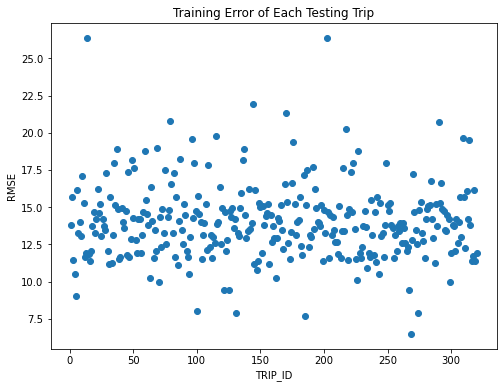

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(range(1,321), rmse_train_lst)

# Add labels and title
plt.xlabel('TRIP_ID')
plt.ylabel('RMSE')
plt.title('Training Error of Each Testing Trip')

# Display the plot
plt.show()

Text(0.5, 1.0, 'Distribution of Training Error of Each Testing Trip')

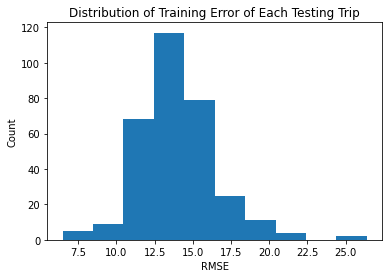

In [35]:
plt.hist(rmse_train_lst)
plt.xlabel('RMSE')
plt.ylabel('Count')
plt.title('Distribution of Training Error of Each Testing Trip')

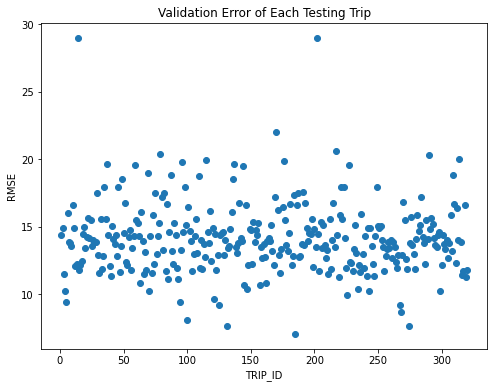

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(range(1,321), rmse_val_lst)

# Add labels and title
plt.xlabel('TRIP_ID')
plt.ylabel('RMSE')
plt.title('Validation Error of Each Testing Trip')

# Display the plot
plt.show()

Text(0.5, 1.0, 'Distribution of Validation Error of Each Testing Trip')

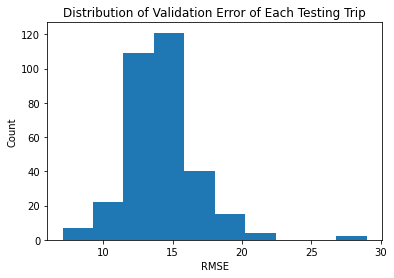

In [38]:
plt.hist(rmse_val_lst)
plt.xlabel('RMSE')
plt.ylabel('Count')
plt.title('Distribution of Validation Error of Each Testing Trip')

In [145]:
top_indices = sorted(range(len(all_train_losses)), 
                     key=lambda i: all_train_losses[i], reverse=True)[:10]

In [146]:
top_train_samples = []
for i in top_indices:
    top_train_samples.append(train_ids[i])

In [95]:
def plot_2d(top, trip_id):
    plt.figure(figsize=(10, 6))
    x = []
    y = []
    # Plot the lines
    for elem in top:
        x.append(elem[0])
        y.append(elem[1])
        
    # Plot the points
    plt.scatter(x, y)

    # Connect the points with lines
    plt.plot(x, y, 'b-')

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'TRIP_ID={trip_id} Visualized in 2D')

    # Display the plot
    plt.show()

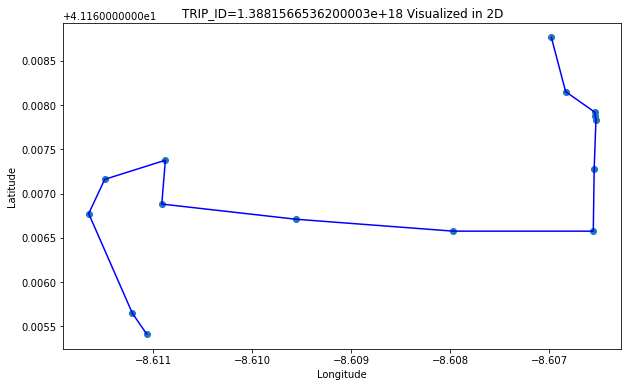

In [96]:
plot_2d(eval(df[df.TRIP_ID == top_train_samples[0]].POLYLINE[837889]), top_train_samples[0])

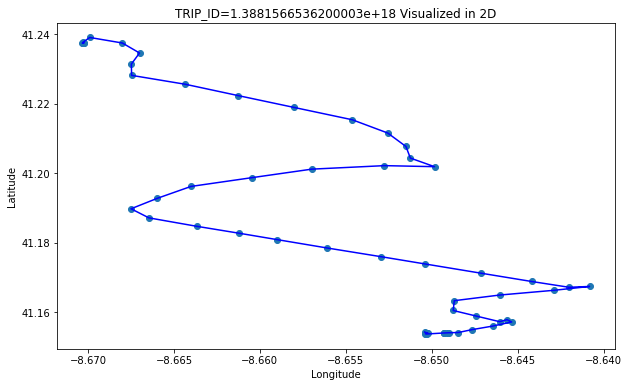

In [113]:
plot_2d(eval(df[df.TRIP_ID == top_train_samples[1]].POLYLINE[1509661]), top_train_samples[1])

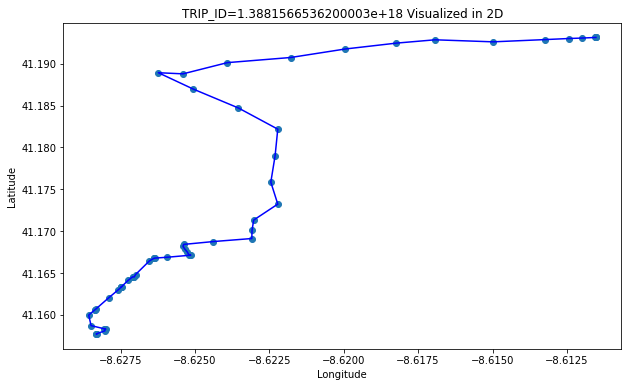

In [116]:
plot_2d(eval(df[df.TRIP_ID == top_train_samples[2]].POLYLINE[794498]), top_train_samples[0])

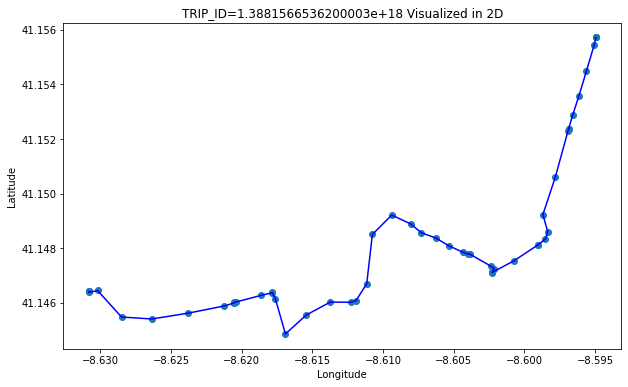

In [118]:
plot_2d(eval(df[df.TRIP_ID == top_train_samples[3]].POLYLINE[928605]), top_train_samples[0])

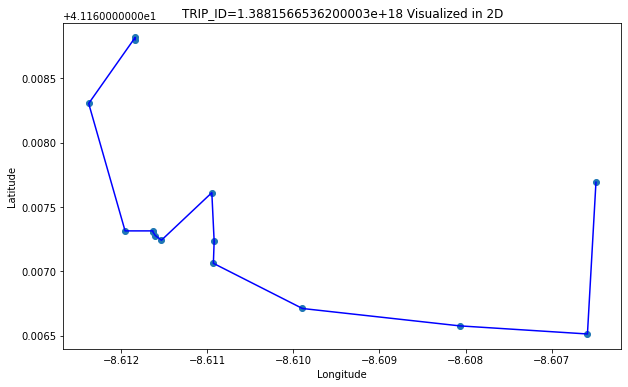

In [120]:
plot_2d(eval(df[df.TRIP_ID == top_train_samples[4]].POLYLINE[928605]), top_train_samples[0])

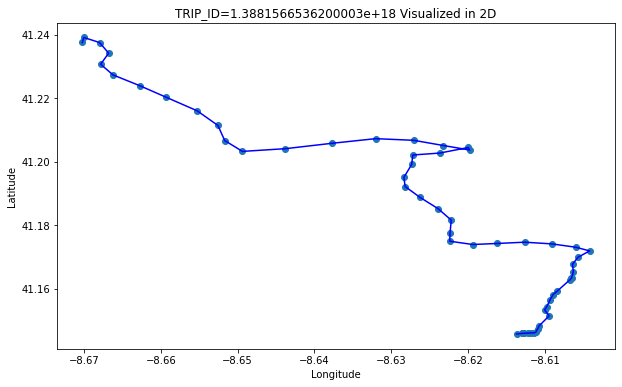

In [122]:
plot_2d(eval(df[df.TRIP_ID == top_train_samples[5]].POLYLINE[1549648]), top_train_samples[0])

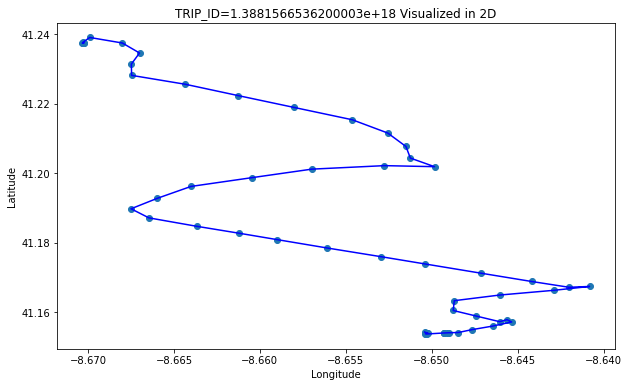

In [124]:
plot_2d(eval(df[df.TRIP_ID == top_train_samples[6]].POLYLINE[1509661]), top_train_samples[0])

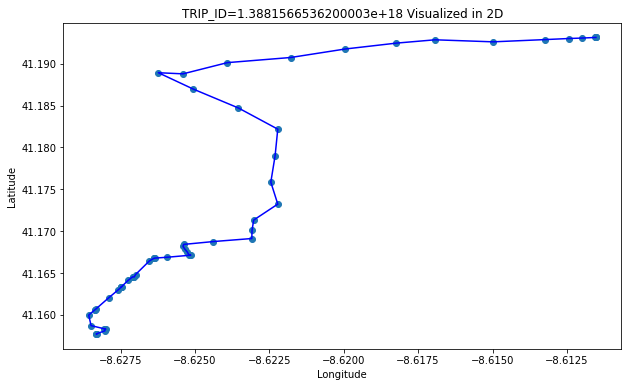

In [126]:
plot_2d(eval(df[df.TRIP_ID == top_train_samples[7]].POLYLINE[794498]), top_train_samples[0])

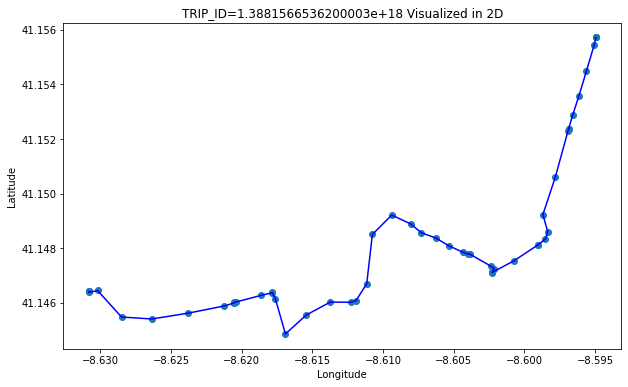

In [128]:
plot_2d(eval(df[df.TRIP_ID == top_train_samples[8]].POLYLINE[928605]), top_train_samples[0])

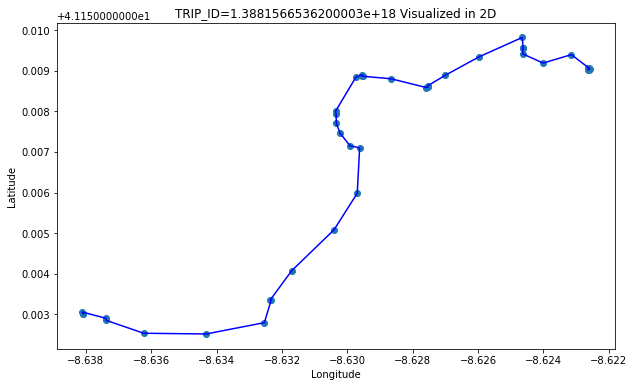

In [148]:
plot_2d(eval(df[df.TRIP_ID == top_train_samples[9]].POLYLINE[912410]), top_train_samples[0])

# Junk below

## T1, T308

In [4]:
dftest[dftest.TAXI_ID == 20000542]

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TIMESTAMP
0,T1,20000542,2014,8,33,14,17,57,3,0,1,0,1,1,0,1408039037
300,T308,20000542,2014,12,51,21,11,41,6,0,0,1,1,1,0,1419162114


In [5]:
## in_data
for taxi_id in [20000542]:
    newtrain=dftrain[dftrain['TAXI_ID'] == taxi_id]
    
    train_corr=newtrain[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY']].corr()
    positive_corr_list=list(train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().keys())
    positive_corr_list.remove('TRAVEL_TIME')

## outlier cut
tmpdf = newtrain
Q1 = tmpdf['TRAVEL_TIME'].quantile(0.25)
Q2 = tmpdf['TRAVEL_TIME'].quantile(0.5)
Q3 = tmpdf['TRAVEL_TIME'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q2

new_train = newtrain[newtrain.TRAVEL_TIME >= lower_bound]
new_train = newtrain[newtrain.TRAVEL_TIME <= upper_bound]

upper_bound

630.0

In [6]:
avail_times = new_train.TRAVEL_TIME.unique()
n = len(avail_times)
range_ = list(range(n))
labels = dict(zip(avail_times,range_))
labels_rev = dict(zip(range_, avail_times))

In [11]:
Xtrain = []
ytrain = []

for row in new_train.iterrows():
    
    lst = []
    for elem in positive_corr_list:#, 'WEEKDAY']:
        lst.append(row[1][elem])

    Xtrain.append(np.array(lst))
    ytrain.append(np.array(labels[row[1]['TRAVEL_TIME']]))

In [12]:
X = Xtrain
y = ytrain

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=42)

# Create an LDA classifier
lda = LinearDiscriminantAnalysis()

# Fit the LDA model on the training data
lda.fit(X_train, y_train)

# Predict the class labels for the test data
y_pred = lda.predict(X_train)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.43333333333333335


In [13]:
new_test = dftest[dftest.TAXI_ID == 20000542]

In [14]:
Xtest = []
#ytest = []

for row in new_test.iterrows():
    lst = []
    for elem in positive_corr_list:#, 'WEEKDAY']:
        lst.append(row[1][elem])
    Xtest.append(np.array(lst))
    #ytest.append(np.array(labels[row[1]['TRAVEL_TIME']]))

In [15]:
lda.predict(Xtest)

array([10,  3])

In [16]:
labels_rev[10]

390

In [17]:
labels_rev[3]

525